# 範例 : 計程車費率預測
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

# [教學目標]
- 使用程車費率預測競賽練習時間欄位處理

# [範例重點]
- 觀察時間特徵分解, 在線性迴歸分數 / 梯度提升樹分數上, 分別有什麼影響 (In[2], Out[2], In[3], Out[3]) 
- 觀察加入週期循環特徵, 在線性迴歸分數 / 梯度提升樹分數上, 分別有什麼影響 (In[4], Out[4], In[5], Out[5]) 

In [84]:
# Import libs
import datetime
import warnings
import pandas as pd
import numpy as np
import math

# Plotting libs
import matplotlib.pyplot as plt

# Machine learning libs
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# Other setups
warnings.simplefilter('ignore')
%matplotlib inline

# File path
data_path = 'data/'

In [85]:
# 讀取資料集
df = pd.read_csv(data_path + 'taxi_data1.csv')

train_Y = df['fare_amount']
df = df.drop(['fare_amount'] , axis=1)
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2011-10-21 23:54:10 UTC,-73.990580,40.761071,-73.981128,40.758634,2
1,2015-02-03 10:42:03 UTC,-73.988403,40.723431,-73.989647,40.741695,1
2,2014-03-16 18:58:58 UTC,-74.015785,40.715110,-74.012029,40.707888,2
3,2009-06-13 16:10:54 UTC,-73.977322,40.787275,-73.958030,40.778838,3
4,2014-06-12 03:25:56 UTC,-73.989683,40.729717,-73.982490,40.761887,3


In [86]:
# 時間轉換方式 : 使用 datetime.strptime 解析(parse)時間字串 / 使用 datetime.strftime 匯出時間格式(format)
df['pickup_datetime'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC'))
df['pickup_year'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%Y')).astype('int64')
df['pickup_month'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%m')).astype('int64')
df['pickup_day'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%d')).astype('int64')
df['pickup_hour'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%H')).astype('int64')
df['pickup_minute'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%M')).astype('int64')
df['pickup_second'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%S')).astype('int64')
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second
0,2011-10-21 23:54:10,-73.990580,40.761071,-73.981128,40.758634,2,2011,10,21,23,54,10
1,2015-02-03 10:42:03,-73.988403,40.723431,-73.989647,40.741695,1,2015,2,3,10,42,3
2,2014-03-16 18:58:58,-74.015785,40.715110,-74.012029,40.707888,2,2014,3,16,18,58,58
3,2009-06-13 16:10:54,-73.977322,40.787275,-73.958030,40.778838,3,2009,6,13,16,10,54
4,2014-06-12 03:25:56,-73.989683,40.729717,-73.982490,40.761887,3,2014,6,12,3,25,56


In [87]:
# 將結果使用線性迴歸 / 梯度提升樹分別看結果
df_temp = df.drop(['pickup_datetime'] , axis=1)
scaler = MinMaxScaler()
train_X = scaler.fit_transform(df_temp)
Linear = LinearRegression()
print(f'Linear Reg Score : {cross_val_score(Linear, train_X, train_Y, cv=5).mean()}')
GDBT = GradientBoostingRegressor()
print(f'Gradient Boosting Reg Score : {cross_val_score(GDBT, train_X, train_Y, cv=5).mean()}')

Linear Reg Score : 0.02687687147563551
Gradient Boosting Reg Score : 0.7111514836282516


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,year_cycle
0,2011-10-21 23:54:10,-73.990580,40.761071,-73.981128,40.758634,2,2011,10,21,23,54,10,-0.939880
1,2015-02-03 10:42:03,-73.988403,40.723431,-73.989647,40.741695,1,2015,2,3,10,42,3,0.544459
2,2014-03-16 18:58:58,-74.015785,40.715110,-74.012029,40.707888,2,2014,3,16,18,58,58,0.960130
3,2009-06-13 16:10:54,-73.977322,40.787275,-73.958030,40.778838,3,2009,6,13,16,10,54,0.318428
4,2014-06-12 03:25:56,-73.989683,40.729717,-73.982490,40.761887,3,2014,6,12,3,25,56,0.343301


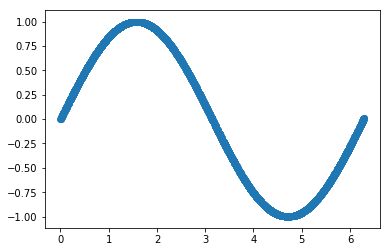

In [88]:
# 年週期
def second_delta_year(df):
    sec_d = (datetime.datetime(df['pickup_year'], df['pickup_month'], df['pickup_day'], 
                               df['pickup_hour'], df['pickup_minute'], df['pickup_second']) -\
             datetime.datetime(df['pickup_year'], 1, 1, 0, 0, 0)).total_seconds()
    return sec_d

sec_d_year = df.apply(second_delta_year, axis=1).astype('int64')
df['year_cycle'] = np.sin(2*np.pi*sec_d_year / (365*24*60*60))
display(df.head())

plt.scatter(2*np.pi*sec_d_year / (365*24*60*60), df['year_cycle']);

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,year_cycle,month_cycle
0,2011-10-21 23:54:10,-73.990580,40.761071,-73.981128,40.758634,2,2011,10,21,23,54,10,-0.939880,-0.897443
1,2015-02-03 10:42:03,-73.988403,40.723431,-73.989647,40.741695,1,2015,2,3,10,42,3,0.544459,0.521708
2,2014-03-16 18:58:58,-74.015785,40.715110,-74.012029,40.707888,2,2014,3,16,18,58,58,0.960130,-0.058936
3,2009-06-13 16:10:54,-73.977322,40.787275,-73.958030,40.778838,3,2009,6,13,16,10,54,0.318428,0.468071
4,2014-06-12 03:25:56,-73.989683,40.729717,-73.982490,40.761887,3,2014,6,12,3,25,56,0.343301,0.722773


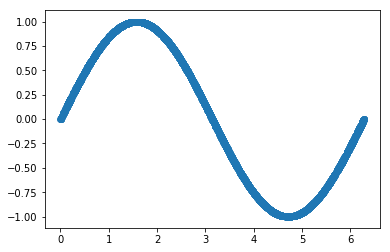

In [89]:
# 月週期
def second_delta_month(df):
    sec_d = (datetime.datetime(df['pickup_year'], df['pickup_month'], df['pickup_day'], 
                               df['pickup_hour'], df['pickup_minute'], df['pickup_second']) -\
             datetime.datetime(df['pickup_year'], df['pickup_month'], 1, 0, 0, 0)).total_seconds()
    return sec_d

sec_d_month = df.apply(second_delta_month, axis=1).astype('int64')
df['month_cycle'] = np.sin(2*np.pi*sec_d_month / (df['pickup_datetime'].dt.daysinmonth*24*60*60))
display(df.head())

plt.scatter(2*np.pi*sec_d_month / (df['pickup_datetime'].dt.daysinmonth*24*60*60), df['month_cycle']);

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,year_cycle,month_cycle,day_cycle
0,2011-10-21 23:54:10,-73.990580,40.761071,-73.981128,40.758634,2,2011,10,21,23,54,10,-0.939880,-0.897443,-0.025450
1,2015-02-03 10:42:03,-73.988403,40.723431,-73.989647,40.741695,1,2015,2,3,10,42,3,0.544459,0.521708,0.333601
2,2014-03-16 18:58:58,-74.015785,40.715110,-74.012029,40.707888,2,2014,3,16,18,58,58,0.960130,-0.058936,-0.967083
3,2009-06-13 16:10:54,-73.977322,40.787275,-73.958030,40.778838,3,2009,6,13,16,10,54,0.318428,0.468071,-0.888817
4,2014-06-12 03:25:56,-73.989683,40.729717,-73.982490,40.761887,3,2014,6,12,3,25,56,0.343301,0.722773,0.782427


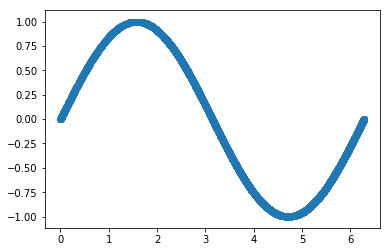

In [90]:
# 日週期
def second_delta_day(df):
    sec_d = (datetime.datetime(df['pickup_year'], df['pickup_month'], df['pickup_day'], 
                               df['pickup_hour'], df['pickup_minute'], df['pickup_second']) -\
             datetime.datetime(df['pickup_year'], df['pickup_month'], df['pickup_day'], 0, 0, 0)).total_seconds()
    return sec_d

sec_d_day = df.apply(second_delta_day, axis=1).astype('int64')
df['day_cycle'] = np.sin(2*np.pi*sec_d_day / (24*60*60))
display(df.head())

plt.scatter(2*np.pi*sec_d_day / (24*60*60), df['day_cycle']);

In [91]:
# 結果 : 預測力反而下降
df_temp = df.drop(['pickup_datetime'] , axis=1)
train_X = scaler.fit_transform(df_temp)
print(f'Linear Reg Score : {cross_val_score(Linear, train_X, train_Y, cv=5).mean()}')
print(f'Gradient Boosting Reg Score : {cross_val_score(GDBT, train_X, train_Y, cv=5).mean()}')

Linear Reg Score : 0.02580238666651218
Gradient Boosting Reg Score : 0.7088349525146286


# 作業1
* 對照範例，試著加入星期幾 (day of week) 與第幾周 (week of year) 這兩項特徵，  
看看結果會比原本只有時間特徵分解的結果更好或更差?

# 作業2
* 對照範例的日週期效果，試著參考投影片完成年週期與周週期的特徵 (也可以用你自己想到的方式)，  
看看結果會比範例中的結果更好或更差?